In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [7]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-10-04 18:33:06--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.005s  

2024-10-04 18:33:06 (40.6 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [8]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [9]:
len(words)

32033

In [132]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [133]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [134]:
n_hidden = 200
embedding_dimension = 10

In [135]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, embedding_dimension), generator=g)
W1 = torch.randn((block_size * embedding_dimension, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [136]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [137]:
for p in parameters:
  p.requires_grad = True

In [138]:
lre = torch.linspace(-3, 0, 1000)
tracking_stat_value = 1000
lrs = 10**lre

In [139]:
lri = []
lossi = []
stepi = []

In [140]:
epochs = 200000

for i in range(epochs):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, block_size * embedding_dimension) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  #lossi.append(loss.item())
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

In [141]:
#plt.plot(stepi, lossi)
#plt.plot(lri, lossi)

In [142]:
 # training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * embedding_dimension) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1270, grad_fn=<NllLossBackward0>)

In [143]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * embedding_dimension) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1838, grad_fn=<NllLossBackward0>)

In [123]:
# What can I change to optmize the model?

# 1. the number of parameters
# 2. number of iterations
# 3. learning rate
# 4. batch size
# 5. context size (i.e. 3+ char)
# 6. number of dimensions for the embeddings vectors

In [144]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * embedding_dimension) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1798, grad_fn=<NllLossBackward0>)

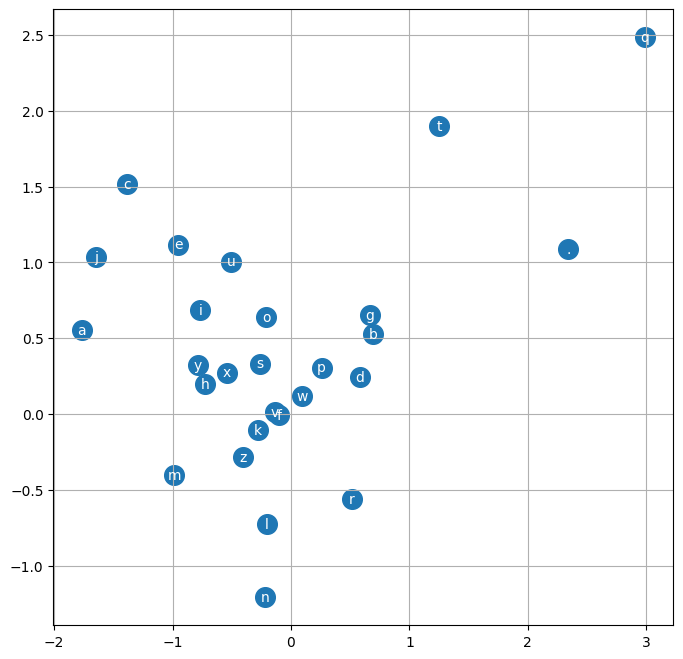

In [102]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [145]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
kayah.
see.
mad.
ryla.
remman.
emgraeg.
aderedielin.
shi.
jen.
eden.
estanara.
aleimalaia.
noshdenrixhiriel.
kindreelynn.
nopustous.
kavdoriyah.
faeha.
kayshustlydi.
halina.


# Exercises:

## E01:
Tune the hyperparameters of the training to beat my best validation loss of 2.2

In [23]:
# Just did it before

# What can I change to optmize the model?

# 1. the number of parameters
# 2. number of iterations
# 3. learning rate
# 4. batch size
# 5. context size (i.e. 3+ char)
# 6. number of dimensions for the embeddings vectors

## E02:
I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

## E03:
Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?